In [205]:
#import all required libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from PIL import Image

In [206]:
#load login data
from google.colab import files
login_file = files.upload()

Saving login.csv to login.csv


In [207]:
#get login info and set api credentials
login = pd.read_csv("login.csv")
consumerKey = login['key'][0]
consumerSecret = login['key'][1]
accessToken = login['key'][2]
accessTokenSecret = login['key'][3]

In [208]:
#create authentication object
authenticate = tweepy.OAuthHandler(consumerKey,consumerSecret)

#set access token and access token secret
authenticate.set_access_token(accessToken,accessTokenSecret)

#create api object by passing authentication object
api = tweepy.API(authenticate,wait_on_rate_limit=True)

In [209]:
#@title Search Twitter For
username = "BillGates" #@param {type:"string"}
#fetch 200 latest tweets from a twitter user
posts = api.user_timeline(screen_name=username, count=200, lang="en", tweet_mode="extended")

# print 5 recent tweets
i=1
for tweet in posts[0:5]:
  print(str(i)+") " + tweet.full_text + "\n")
  i=i+1

1) Here in Washington, we always vote by mail. It's a safe and secure way to shape the future of our country. But regardless of whether you vote by mail or in person this year, I hope you plan to make your voice heard. Visit https://t.co/TmsHAC9MGv for more information.

2) @MohamedBinZayed The UAE is an essential partner in stopping polio in Pakistan. Thank you @MohamedBinZayed for your continued commitment to polio eradication.

3) For decades, @Rotary has worked tirelessly to #EndPolio. Today, the health infrastructure they’ve built around the world is supporting the COVID-19 response. #WorldPolioDay https://t.co/67liH7akNH

4) RT @StephenCurry30: Even with his busy schedule, Dr. Fauci took the time to sit down with me (AGAIN) and talk about what we’ve gotten right…

5) I’ve been working for some time on a book about what we need to do over the next decade to avoid a climate disaster. I’m excited that it will be published on February 16. https://t.co/M9QYX93fd5



In [210]:
#Information and Statistics
print("Name: ",posts[0].user.name)
print("Joined Twitter On: ", posts[0].user.created_at)
print("Location: ",posts[0].user.location)
print("Bio: ",posts[0].user.description)
print("URL: ",posts[0].user.url)
print("Tweets: ",posts[0].user.statuses_count)
print("Followers: ",posts[0].user.followers_count)
print("Following: ",posts[0].user.friends_count)

Name:  Bill Gates
Joined Twitter On:  2009-06-24 18:44:10
Location:  Seattle, WA
Bio:  Sharing things I'm learning through my foundation work and other interests.
URL:  https://t.co/emd1hfqSRD
Tweets:  3404
Followers:  52460706
Following:  240


In [211]:
#create dataframe with Tweets, Timestamp, Source and Retweet columns
data = pd.DataFrame()
data['Tweets']=[tweet.full_text for tweet in posts]
data['Timestamp']=[tweet.created_at for tweet in posts]
data['Source']=[tweet.source for tweet in posts]
data['Retweet']=[tweet.retweet_count for tweet in posts]
data

,Tweets,Timestamp,Source,Retweet
0,"Here in Washington, we always vote by mail. It...",2020-10-28 20:07:52,Twitter Web App,336
1,@MohamedBinZayed The UAE is an essential partn...,2020-10-27 15:53:16,Twitter Web App,170
2,"For decades, @Rotary has worked tirelessly to ...",2020-10-23 18:49:51,Twitter Web App,494
3,RT @StephenCurry30: Even with his busy schedul...,2020-10-20 18:30:42,Twitter Web App,1194
4,I’ve been working for some time on a book abou...,2020-10-19 20:48:29,Twitter Web App,881
...,...,...,...,...
195,"The incredible, diverse global partnership tha...",2019-11-20 17:24:40,Sprinklr,395
196,Some of our most vital partners in the fight t...,2019-11-20 04:43:01,Sprinklr,508
197,Even a single child paralyzed by polio is one ...,2019-11-20 01:25:00,Sprinklr,638
198,"In Abu Dhabi this week, the world committed $2...",2019-11-19 22:51:08,Sprinklr,1219


In [212]:
#separate date and time from timestamp
data['Date']=[ts.date() for ts in data['Timestamp'] ]
data['Time']=[ts.time() for ts in data['Timestamp'] ]
data['Hour'] = [ t.hour for t in data['Time'] ]
data

,Tweets,Timestamp,Source,Retweet,Date,Time,Hour
0,"Here in Washington, we always vote by mail. It...",2020-10-28 20:07:52,Twitter Web App,336,2020-10-28,20:07:52,20
1,@MohamedBinZayed The UAE is an essential partn...,2020-10-27 15:53:16,Twitter Web App,170,2020-10-27,15:53:16,15
2,"For decades, @Rotary has worked tirelessly to ...",2020-10-23 18:49:51,Twitter Web App,494,2020-10-23,18:49:51,18
3,RT @StephenCurry30: Even with his busy schedul...,2020-10-20 18:30:42,Twitter Web App,1194,2020-10-20,18:30:42,18
4,I’ve been working for some time on a book abou...,2020-10-19 20:48:29,Twitter Web App,881,2020-10-19,20:48:29,20
...,...,...,...,...,...,...,...
195,"The incredible, diverse global partnership tha...",2019-11-20 17:24:40,Sprinklr,395,2019-11-20,17:24:40,17
196,Some of our most vital partners in the fight t...,2019-11-20 04:43:01,Sprinklr,508,2019-11-20,04:43:01,4
197,Even a single child paralyzed by polio is one ...,2019-11-20 01:25:00,Sprinklr,638,2019-11-20,01:25:00,1
198,"In Abu Dhabi this week, the world committed $2...",2019-11-19 22:51:08,Sprinklr,1219,2019-11-19,22:51:08,22


Twitter Web App         137
Sprinklr                 48
Twitter Media Studio     14
Twitter for Android       1
Name: Source, dtype: int64


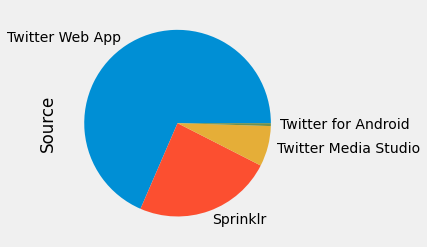

In [213]:
# display counts of each source
print(data['Source'].value_counts())

#plot and visualize sources
plt.style.use('fivethirtyeight')
data['Source'].value_counts().plot(kind='pie')
plt.show()

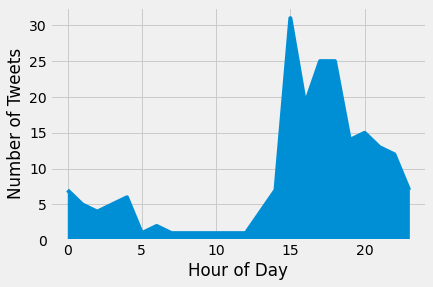

In [214]:
#plot and visualize when the user tweeted maximum times in a day
plt.style.use('fivethirtyeight')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Tweets")
data['Hour'].value_counts(sort=False).plot(kind='area')
plt.show()

In [215]:
#clean/preprocess tweets

def cleanText(text):
  text = re.sub('@[A-z0-9]+','',text) #remove @mentions
  text = re.sub('#','',text) #remove '#' symbol
  text = re.sub('RT[\s]','',text) #remove retweet mentions
  text = re.sub('https?:\/\/\S+','',text) #remove hyperlinks
  text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','',text) #remove punctuations

  return text

#apply cleanText function to Tweets column and display cleaned tweets
data['Tweets'] = data['Tweets'].apply(cleanText)

data

,Tweets,Timestamp,Source,Retweet,Date,Time,Hour
0,Here in Washington we always vote by mail Its ...,2020-10-28 20:07:52,Twitter Web App,336,2020-10-28,20:07:52,20
1,The UAE is an essential partner in stopping p...,2020-10-27 15:53:16,Twitter Web App,170,2020-10-27,15:53:16,15
2,For decades has worked tirelessly to EndPolio...,2020-10-23 18:49:51,Twitter Web App,494,2020-10-23,18:49:51,18
3,Even with his busy schedule Dr Fauci took the...,2020-10-20 18:30:42,Twitter Web App,1194,2020-10-20,18:30:42,18
4,I’ve been working for some time on a book abou...,2020-10-19 20:48:29,Twitter Web App,881,2020-10-19,20:48:29,20
...,...,...,...,...,...,...,...
195,The incredible diverse global partnership that...,2019-11-20 17:24:40,Sprinklr,395,2019-11-20,17:24:40,17
196,Some of our most vital partners in the fight t...,2019-11-20 04:43:01,Sprinklr,508,2019-11-20,04:43:01,4
197,Even a single child paralyzed by polio is one ...,2019-11-20 01:25:00,Sprinklr,638,2019-11-20,01:25:00,1
198,In Abu Dhabi this week the world committed 26B...,2019-11-19 22:51:08,Sprinklr,1219,2019-11-19,22:51:08,22


In [216]:
#download and display stopwords of english language
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [217]:
#remove stopwords from tweets
def removeStopwords(text):
  text_words = [ word for word in text.split() if word.lower() not in stopwords.words('english')]
  text = ' '.join(text_words)
  return text;

#apply removeStopwords function to Tweets column
data['Tweets'] = data['Tweets'].apply(removeStopwords)

data

,Tweets,Timestamp,Source,Retweet,Date,Time,Hour
0,Washington always vote mail safe secure way sh...,2020-10-28 20:07:52,Twitter Web App,336,2020-10-28,20:07:52,20
1,UAE essential partner stopping polio Pakistan ...,2020-10-27 15:53:16,Twitter Web App,170,2020-10-27,15:53:16,15
2,decades worked tirelessly EndPolio Today healt...,2020-10-23 18:49:51,Twitter Web App,494,2020-10-23,18:49:51,18
3,Even busy schedule Dr Fauci took time sit talk...,2020-10-20 18:30:42,Twitter Web App,1194,2020-10-20,18:30:42,18
4,I’ve working time book need next decade avoid ...,2020-10-19 20:48:29,Twitter Web App,881,2020-10-19,20:48:29,20
...,...,...,...,...,...,...,...
195,incredible diverse global partnership halted w...,2019-11-20 17:24:40,Sprinklr,395,2019-11-20,17:24:40,17
196,vital partners fight EndPolio philanthropies l...,2019-11-20 04:43:01,Sprinklr,508,2019-11-20,04:43:01,4
197,Even single child paralyzed polio one many I’m...,2019-11-20 01:25:00,Sprinklr,638,2019-11-20,01:25:00,1
198,Abu Dhabi week world committed 26B EndPolio Th...,2019-11-19 22:51:08,Sprinklr,1219,2019-11-19,22:51:08,22


In [218]:
#get subjectivity and polarity of tweets
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#create 2 new columns and display new dataframe
data['Subjectivity']=data['Tweets'].apply(getSubjectivity)
data['Polarity']=data['Tweets'].apply(getPolarity)

data

,Tweets,Timestamp,Source,Retweet,Date,Time,Hour,Subjectivity,Polarity
0,Washington always vote mail safe secure way sh...,2020-10-28 20:07:52,Twitter Web App,336,2020-10-28,20:07:52,20,0.408333,0.300000
1,UAE essential partner stopping polio Pakistan ...,2020-10-27 15:53:16,Twitter Web App,170,2020-10-27,15:53:16,15,0.300000,0.000000
2,decades worked tirelessly EndPolio Today healt...,2020-10-23 18:49:51,Twitter Web App,494,2020-10-23,18:49:51,18,0.250000,0.250000
3,Even busy schedule Dr Fauci took time sit talk...,2020-10-20 18:30:42,Twitter Web App,1194,2020-10-20,18:30:42,18,0.300000,0.100000
4,I’ve working time book need next decade avoid ...,2020-10-19 20:48:29,Twitter Web App,881,2020-10-19,20:48:29,20,0.375000,0.187500
...,...,...,...,...,...,...,...,...,...
195,incredible diverse global partnership halted w...,2019-11-20 17:24:40,Sprinklr,395,2019-11-20,17:24:40,17,0.433333,0.333333
196,vital partners fight EndPolio philanthropies l...,2019-11-20 04:43:01,Sprinklr,508,2019-11-20,04:43:01,4,0.400000,0.100000
197,Even single child paralyzed polio one many I’m...,2019-11-20 01:25:00,Sprinklr,638,2019-11-20,01:25:00,1,0.304762,0.209524
198,Abu Dhabi week world committed 26B EndPolio Th...,2019-11-19 22:51:08,Sprinklr,1219,2019-11-19,22:51:08,22,1.000000,-1.000000


(-0.5, 813.5, 667.5, -0.5)

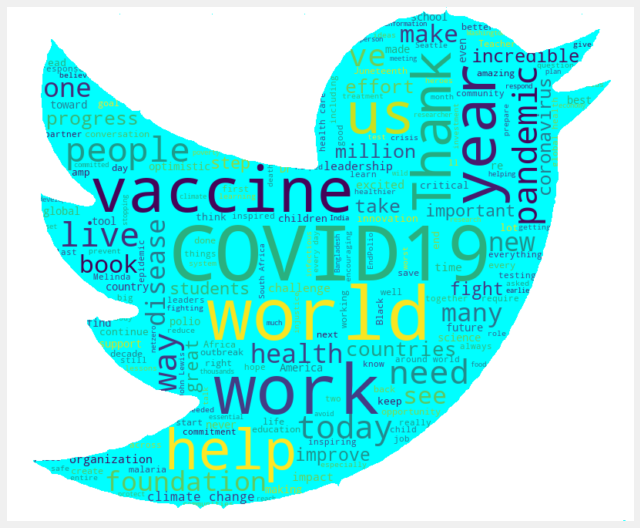

In [219]:
#plot wordcloud
words = ' '.join( [ tweet for tweet in data['Tweets'] ])
mask = np.array(Image.open("twitter.png"))
wc = WordCloud(width=500,height=300,mask=mask,random_state=21,max_font_size=100,background_color="cyan",contour_width=30, contour_color="white").generate(words)
wc.to_file("cloud.png")
plt.figure(figsize = (10,10))
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")

In [220]:
#compute positive, neutral or negative label
def getLabel(label):
  if label < 0:
    return "Negative"
  elif label == 0:
    return "Neutral"
  else:
    return "Positive"

#create new column for label and display new dataframe
data['Label'] = data['Polarity'].apply(getLabel)

data

,Tweets,Timestamp,Source,Retweet,Date,Time,Hour,Subjectivity,Polarity,Label
0,Washington always vote mail safe secure way sh...,2020-10-28 20:07:52,Twitter Web App,336,2020-10-28,20:07:52,20,0.408333,0.300000,Positive
1,UAE essential partner stopping polio Pakistan ...,2020-10-27 15:53:16,Twitter Web App,170,2020-10-27,15:53:16,15,0.300000,0.000000,Neutral
2,decades worked tirelessly EndPolio Today healt...,2020-10-23 18:49:51,Twitter Web App,494,2020-10-23,18:49:51,18,0.250000,0.250000,Positive
3,Even busy schedule Dr Fauci took time sit talk...,2020-10-20 18:30:42,Twitter Web App,1194,2020-10-20,18:30:42,18,0.300000,0.100000,Positive
4,I’ve working time book need next decade avoid ...,2020-10-19 20:48:29,Twitter Web App,881,2020-10-19,20:48:29,20,0.375000,0.187500,Positive
...,...,...,...,...,...,...,...,...,...,...
195,incredible diverse global partnership halted w...,2019-11-20 17:24:40,Sprinklr,395,2019-11-20,17:24:40,17,0.433333,0.333333,Positive
196,vital partners fight EndPolio philanthropies l...,2019-11-20 04:43:01,Sprinklr,508,2019-11-20,04:43:01,4,0.400000,0.100000,Positive
197,Even single child paralyzed polio one many I’m...,2019-11-20 01:25:00,Sprinklr,638,2019-11-20,01:25:00,1,0.304762,0.209524,Positive
198,Abu Dhabi week world committed 26B EndPolio Th...,2019-11-19 22:51:08,Sprinklr,1219,2019-11-19,22:51:08,22,1.000000,-1.000000,Negative


In [221]:
#print all tweets with positive label
j = 1
sortedData = data.sort_values(by="Polarity")
for i in range(0,sortedData.shape[0]):
  if sortedData['Label'][i] == "Positive":
    print(str(j) + ") "+sortedData['Tweets'][i])
    j=j+1

1) Washington always vote mail safe secure way shape future country regardless whether vote mail person year hope plan make voice heard Visit information
2) decades worked tirelessly EndPolio Today health infrastructure they’ve built around world supporting COVID19 response WorldPolioDay
3) Even busy schedule Dr Fauci took time sit talk we’ve gotten right…
4) I’ve working time book need next decade avoid climate disaster I’m excited published February 16
5) It’s inspiring see much passion days dealing climate change know world set ambitious goals solving need practical plans reach goals
6) India’s research manufacturing capacity critical fighting COVID19 Thank speaking today’s Grand Challenges meeting
7) Europe opportunity get economy back track way creates good jobs reinforces global climate leadership 55 ideas Europe develop scale innovative technologies well need reach netzero
8) ’s work community inspiring amazing record basketball court really appreciated thoughtful conversation
9

In [222]:
#print all tweets with negative label
j = 1
sortedData = data.sort_values(by="Polarity")
for i in range(0,sortedData.shape[0]):
  if sortedData['Label'][i] == "Negative":
    print(str(j) + ") "+sortedData['Tweets'][i])
    j=j+1

1) prevent worst effects climate change need innovation across sectors—especially hardest decarbonize sectors—to get us viable path netzero emissions
2) longstanding barriers made worse COVID19 hundreds thousands students promise may never start college would disastrous young people country Here’s we’re help
3) learn lessons COVID19 approach climate change informed consequences inaction prepared save lives prevent worst possible outcome
4) hero playing critical role Kenya’s preparations tackle COVID19 scaling medical oxygen supplies needed keep critically ill patients alive
5) “It’s clarity language VALUE black life America distinguishes Juneteenth emancipation…
6) “Only feigning blindness fail see body work work body done Everything is…
7) Juneteenth recognizes amp celebrates Black people’s freedom end slavery US 19 Jun 1865 Union Army Genera…
8) 1 Opal Lee force behind movement make Juneteenth national holiday Also known Freedom Day it…
9) committed listening learning systemic racism

In [223]:
#print all tweets with neutral label
j = 1
sortedData = data.sort_values(by="Polarity")
for i in range(0,sortedData.shape[0]):
  if sortedData['Label'][i] == "Neutral":
    print(str(j) + ") "+sortedData['Tweets'][i])
    j=j+1

1) UAE essential partner stopping polio Pakistan Thank continued commitment polio eradication
2) COVID19 pandemic set back efforts end poverty hunger malnutrition Investing speed recovery helping farmers adapt climate change rebuild food systems pandemic via
3) honor well deserved COVID19 health crisis—it also food crisis respond I’m inspired thousands people organization committed lives fighting hunger
4) last 25 years Dr Firdausi Qadri immunologist infectious disease researcher Bangladesh working protect entire communities cholera epidemics
5) COVID19 malaria COVID19 struck disrupted entire global healt…
6) Deaths malaria cut half since year 2000 Increased bed net use one main reasons WorldMosquitoDay
7) Vaccines prevent millions deaths every year harnessing body’s immune system create defences future infection…
8) community health worker Kenya’s Homa Bay County Evaline helped community dramatically reduce number of…
9) Move aside still world’s deadliest killer
10) commitment critica

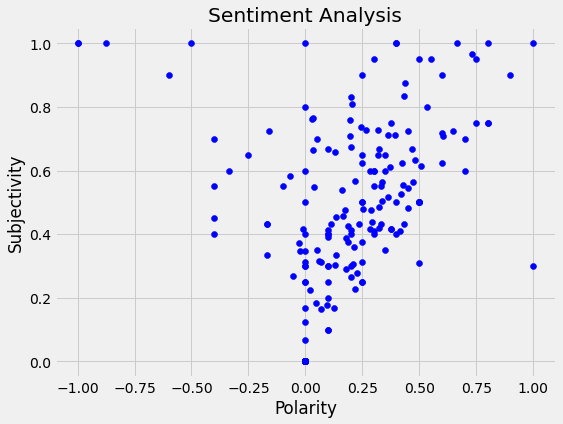

In [224]:
#plot polarity and subjectivity using scatterplot
plt.figure(figsize=(8,6))
for i in range(0, data.shape[0]):
  plt.scatter(data['Polarity'][i],data['Subjectivity'][i],color="blue")

plt.title("Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()

In [225]:
#get percentage of positive tweets
ptweets = data[data['Label']=="Positive"]
ptweets = ptweets['Tweets']
print("Percentage of Positive Tweets:")
print(round(ptweets.shape[0]/data.shape[0] *100, 1))

Percentage of Positive Tweets:
68.0


In [226]:
#get percentage of negative tweets
ntweets = data[data['Label']=="Negative"]
ntweets = ntweets['Tweets']
print("Percentage of Negative Tweets:")
print(round(ntweets.shape[0]/data.shape[0] *100, 1))

Percentage of Negative Tweets:
10.5


In [227]:
#get percentage of neutral tweets
tweets = data[data['Label']=="Neutral"]
tweets = tweets['Tweets']
print("Percentage of Neutral Tweets:")
print(round(tweets.shape[0]/data.shape[0] *100, 1))

Percentage of Neutral Tweets:
21.5


Positive    136
Neutral      43
Negative     21
Name: Label, dtype: int64


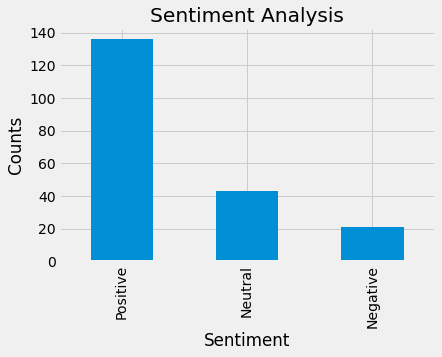

In [228]:
# display counts of each label
print(data['Label'].value_counts())

#plot and visualize counts
plt.style.use('fivethirtyeight')
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
data['Label'].value_counts().plot(kind='bar')
plt.show()